# Evaluating energy consumption of low-income households

Ben Neiman <br/>
March 8, 2018
### Table of Contents
1. [Abstract](#abs)
2. [Introduction](#intro)<br/>
    2.1 [Problem Statement](#problem)<br/>
    2.2 [Time-of-Use Tariffs](#tou)<br/>
    2.2 [Data](#data)
3. [Results](#res)<br/>
    3.1 [Measuring the effectiveness of ToU tariffs](#tariffs)<br/>
    3.2 [Weather effect on low-income consumption](#weather)<br/>
    3.3 [K-Means clustering of load curves](#kmeans)
4. [Conclusion](#con)

### 1. Abstract
<a id = 'abs'></a>

There are myriad approaches to combat climate change around the world, moving to clean energy sources, automobile electrification, and energy-efficient building standards are a few examples. One method that has gained increasing popularity are Time-of-Use tariffs on household energy consumption. This notebook explores the effectiveness of said tariffs and how they could be further utilized to help reduce electricity bills for low-income households.

### 2. Introduction
<a id = 'intro'></a>
#### 2.1 Problem Statement
<a id = 'problem'></a>
This project was inspired by articles in [The Atlantic](https://www.theatlantic.com/business/archive/2016/04/why-poor-americans-have-some-of-the-highest-electricity-bills/478551/) and the [Environmental Defense Fund](http://blogs.edf.org/energyexchange/2018/02/26/californias-disadvantaged-communities-could-benefit-from-time-of-use-electricity-prices-but-it-wont-happen-automatically/). Research has shown that electricity bills do not scale linearly with household income, the bottom 20% households typically pay fives times as much of their monthly income on electricity as the top 20% of households do (9.92% v. 1.38%). This can be at least partially be attributed to the fact that poorer families live in older buildings that are not as energy efficient as their newer counterparts. Clearly there is a pressing need to reduce the burden of high electricity bills on low-income households.
#### 2.2 Time-of-Use Tariffs
<a id = 'tou'></a>
Time-of-Use tariffs are a way of incentivizing households to change their energy usage behavior in order to relieve stress on the grid. Due to the typical person's work/sleep schedule most people will use the most electricity in the mornings before they leave their house and in the evenings when they get. This can put stress on the grid and require higher baseloads from dirtier energy sources like coal. By charging consumers more for electricity during these "peak" hours and less during "off-peak" hours, such as late at night and early in the morning, utilities can smooth out the distribution of energy usage to reduce congestion on the grid.
#### 2.3 Data
<a id = 'data'></a>
The bulk of the data used came from this post on [Kaggle](https://www.kaggle.com/jeanmidev/smart-meters-in-london). The original consumption data was collected at half-hourly intervals from 2011 to 2014 across 5,567 London homes by the UK Power Network as part of a project to determine how to implement smart meters across the city. The tariffs data was also provided by UK Power Networks on an hourly basis for all of 2013. The weather data was collected on an hourly interval using the dark sky API from 2011-2014 and provided in the Kaggle post.

In [135]:
import pymysql
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.stats as stats
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
%matplotlib inline

##### Loading Data

The smart meter data was hosted in a MySQL database to save space and speed up performance. The data was pared down to just 2013 as that is when there is corresponding tariff data.

In [6]:
login_info = {'host':'uw-data-science.cguucsvr8od7.us-west-2.rds.amazonaws.com',
             'user':'bneiman',
             'password':'datasc1ence',
             'db':'smart_meter_project'}

local_info = {'host':'127.0.01',
              'user':'root',
             'db':'uw_ds'}


In [7]:
# Connect to database using SQLAlchemy library
def loadDataSA(creds,sql):
    conn_string = 'mysql+pymysql://{username}@{host}:3306/{db}'.format(username = creds['user'],
                                                                                 #password = creds['password'],
                                                                                 host = creds['host'],
                                                                                 db = creds['db'])
    engine = create_engine(conn_string)
    results = engine.execute(sql).fetchall()
    data = pd.DataFrame(results)
    return data

In [8]:
# Specify SQL Query
sql = 'SELECT LCLid, stdorToU, DateTime, `kWh/hh`,Acorn_grouped from smart_meter_2013 WHERE DateTime BETWEEN "2013-01-01" \
        and "2014-01-01" AND (`Acorn_grouped` = "Adversity" OR `Acorn_grouped` = "Affluent")'

In [9]:
'''
Load main dataset
use login_info for remote access
use local_info for local access

NOTE: This can take over an hour to run when connecting to AWS depending on connection
'''
data = loadDataSA(login_info,sql)

In [10]:
# Load tariff data
sql2 = 'SELECT * FROM tariffs'
tariffs = loadDataSA(local_info,sql2)
# Format dataframe
tariffs.columns = ['DateTime','tariff']
tariffs = tariffs.set_index('DateTime')
# Encode categorical variables
#tariffs['tariff'] = tariffs.tariff.map({'Low':0,'Normal':1,'High':2})

In [11]:
data.columns = ['LCLid','stdorToU','DateTime','kWh/hh','Class']
data['kWh/hh'] = data['kWh/hh'].astype('float')
data = data[data.DateTime.dt.year == 2013]

In [12]:
data.head()

,LCLid,stdorToU,DateTime,kWh/hh,Class
0,MAC000002,Std,2013-01-01 00:00:00,0.219,Affluent
1,MAC000002,Std,2013-01-01 00:30:00,0.241,Affluent
2,MAC000002,Std,2013-01-01 01:00:00,0.191,Affluent
3,MAC000002,Std,2013-01-01 01:30:00,0.235,Affluent
4,MAC000002,Std,2013-01-01 02:00:00,0.182,Affluent


### 3. Results
<a id = 'res'></a>
#### 3.1 Measuring the effectiveness of ToU Tariffs
<a id = 'tariffs'></a>

To start the analysis, I performed a T-test on the hourly consumption data of low-income households with and without a ToU tariff. The T-test allows us to measure how likely the differences between to arrays occur by chance. In this case our hypotheses will be:<br/>

$ H_{0}$ = there is no difference between energy use with and without tariffs <br/>
$H_{A}$ = there is a significant difference between energy use with and without tariffs

In [13]:
# Segment data into by income level and whether or not they are receiving ToU tariff
low_std_data = data[(data['stdorToU'] == 'Std') & (data['Class'] == 'Adversity')].copy()
low_ToU_data = data[(data['stdorToU'] == 'ToU') & (data['Class'] == 'Adversity')].copy()
# Resample to hourly to match 
low_ToU_hourly = low_ToU_data.groupby('DateTime')['kWh/hh'].mean().resample('1h').sum()
low_std_hourly = low_std_data.groupby('DateTime')['kWh/hh'].mean().resample('1h').sum()

In [14]:
low_ToU_ttest = low_ToU_data.copy()
low_std_ttest = low_std_data.copy()

In order to normalize the data for comparison, I removed the seasonality from each household load profile before averaging the hourly consumption.

In [15]:
# remove seasonality of consumption data
def adjustSeasonality(vector):
    '''
    This function takes a vector of hourly consumption data, calculates the seasonality based 
    on a daily basis and then subtracts the corresponding value from the original hourly data.
    '''
    daily_avg_std = vector.resample('D').mean().values

    lp = 14
    seasonal = []
    rng = int(len(daily_avg_std))
    # append the moving average using a 14 day window
    for i in range(int(len(daily_avg_std))):
        seasonal.append(np.mean(daily_avg_std[np.max([i-lp,0]):np.min([i+lp,rng])]))
    adj_cons = []
    # subtract the daily value from all 24 hour values in that day
    for i in range(len(vector)):
        adj_cons.append(vector[i]-daily_avg_std[i//24])
        
    return adj_cons

In [16]:
# Pivot data so each customer is a unique column
low_ToU_ttest_pvt = low_ToU_ttest.pivot_table(index = 'DateTime',columns = 'LCLid',values = 'kWh/hh')

low_ToU_ttest_adj = low_ToU_ttest_pvt.copy().resample('1h').sum().apply(lambda x: adjustSeasonality(x))

low_ToU_ttest_means = low_ToU_ttest_adj.apply(lambda x: np.mean(x),axis = 1)

In [17]:
# Repeat process for std customers
low_std_ttest_pvt = low_std_ttest.pivot_table(index = 'DateTime',columns = 'LCLid',values = 'kWh/hh')

low_std_ttest_adj = low_std_ttest_pvt.copy().resample('1h').sum().apply(lambda x: adjustSeasonality(x))

low_std_ttest_means = low_std_ttest_adj.apply(lambda x: np.mean(x),axis = 1)

In [20]:
results = stats.ttest_ind(low_std_ttest_means,low_ToU_ttest_means)

In [21]:
print('The test statistic is: {}'.format(results[0]))
print('The p-value of the test statistic is: {}'.format(results[1]))

The test statistic is: 4.767217796490433e-16
The p-value of the test statistic is: 0.9999999999999996


What this tells us is that any differences between the two arrays is due to chance, and not a significant difference. This would seem to counter the argument that time-of-use tariffs are an effective method of changing consumption patterns. However, let's look at the tariffs from 2013. While the initial conclusion to draw here is that time-of-use are ineffective, digging into the tariffs themselves shows that may not be the case here.

In [143]:
# Calculate frequency high and low tariffs were issued
low_tariff_perc = tariffs.tariff.value_counts()['Low']/tariffs.tariff.value_counts().sum()
hi_tariff_perc = tariffs.tariff.value_counts()['High']/tariffs.tariff.value_counts().sum()

print('High tariffs were in effect for {}% of all hours in 2013'.format(round(hi_tariff_perc*100,2)))

print('Low tariffs were in effect for {}% of all hours in 2013'.format(round(low_tariff_perc*100,2)))

High tariffs were in effect for 4.5% of all hours in 2013
Low tariffs were in effect for 9.48% of all hours in 2013


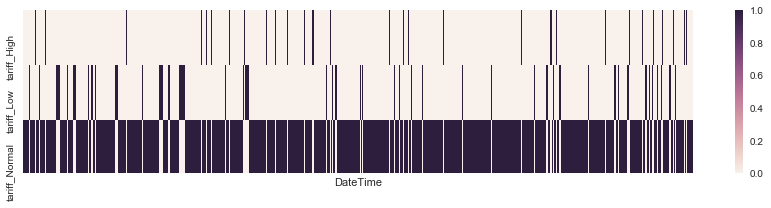

In [144]:
# one-hot encode tariffs for heatmap
tariffs_enc = pd.get_dummies(tariffs).resample('1h').mean()

sns.set(rc={'figure.figsize':(15,3)})
sns.heatmap(tariffs_enc.T)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

The frequency and distribution of the tariffs used show appear to not be very well allocated. Tariffs, high and low, were levied less than 15% of the time total, and from the heatmap it's clear that they were not levied with any sort of regularity. The purpose of these tariffs is to entice consumers to change their energy habits to take advantage of lower electricity prices, by levying these tariffs infrequently and unevenly it makes it hard for consumers to develop these habits.

#### 3.2 Weather effect on low-income consumption
<a id='weather'></a>
One method that could improve how tariffs are distributed is by levying based on forecast. Theoretically, on hot days a household would use more electricity for their A/C or keep more lights on during a cloudy day. By understanding the relationship between weather and energy consumption a utility could predict how households would consume electricity based on the forecast and plan tariffs accordingly. This section will use multiple linear regression to assess the strength of that relationship.

In [23]:
# Prepare energy consumption data
low_inc_data = low_std_data.copy()
# Pivot data so each customer is a column
low_inc_data2 = low_inc_data.pivot_table(index = 'DateTime',columns = 'LCLid',values = 'kWh/hh')
# Resample to hourly to match weather data interval
low_inc_data3 = low_inc_data2.resample('1h').sum()

In [145]:
# Take hourly means across all customers
low_inc_means = pd.DataFrame(low_inc_data3.apply(lambda x: np.mean(x),axis = 1),columns = ['kWh/h'])

In [146]:
# Scale the means
low_inc_means_scld = pd.DataFrame(low_inc_means,columns=['kWh/h']).apply(lambda x: preprocessing.scale(x))

In [147]:
# Load weather data from CSV, select only 2013 data
weather_data = pd.read_csv('weather_hourly_darksky.csv')
weather_data['time'] = pd.to_datetime(weather_data.time,infer_datetime_format=True)
weather_data_2013 = weather_data[weather_data.time.dt.year == 2013]
weather_data_2013 = weather_data_2013.set_index('time')

In [148]:
# Check for any missing values
weather_data_2013.isna().sum()

visibility             0
windBearing            0
temperature            0
dewPoint               0
pressure               9
apparentTemperature    0
windSpeed              0
precipType             0
icon                   0
humidity               0
summary                0
dtype: int64

In [149]:
# Interpolate missing values 
weather_data_2013.pressure = weather_data_2013.pressure.interpolate()
# Check that there is nothing missing now
weather_data_2013.pressure.isna().sum()

0

In [150]:
# Check data types to see if any variables are categorical
weather_data_2013.dtypes

visibility             float64
windBearing              int64
temperature            float64
dewPoint               float64
pressure               float64
apparentTemperature    float64
windSpeed              float64
precipType              object
icon                    object
humidity               float64
summary                 object
dtype: object

In [151]:
# One-hot encode all categorical variables
weather_data_2013_encd = pd.get_dummies(weather_data_2013)

In [152]:
# Scale all features
weather_data_2013_scld = weather_data_2013_encd.apply(lambda x: preprocessing.scale(x),axis = 0)

In [153]:
# Let's look at the new dataset, encoded and scaled.
weather_data_2013_scld.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,precipType_rain,precipType_snow,...,summary_Breezy and Overcast,summary_Breezy and Partly Cloudy,summary_Clear,summary_Foggy,summary_Mostly Cloudy,summary_Overcast,summary_Partly Cloudy,summary_Windy,summary_Windy and Mostly Cloudy,summary_Windy and Overcast
time,,,,,,,,,,,,,,,,,,,,,
2013-12-31 23:00:00,0.237580,0.089930,-0.522498,-0.203481,-1.227489,-0.696278,0.800963,0.706553,0.219909,-0.219909,...,-0.083749,-0.105828,1.423468,-0.168215,-0.657966,-0.286419,-0.523169,-0.030237,-0.021376,-0.0239
2013-12-31 22:00:00,0.652114,0.029484,-0.660485,-0.358809,-1.205161,-0.808789,0.524279,0.706553,0.219909,-0.219909,...,-0.083749,-0.105828,1.423468,-0.168215,-0.657966,-0.286419,-0.523169,-0.030237,-0.021376,-0.0239
2013-12-31 21:00:00,0.601484,-0.020887,-0.756610,-0.634165,-1.161476,-0.877330,0.267358,0.296675,0.219909,-0.219909,...,-0.083749,-0.105828,1.423468,-0.168215,-0.657966,-0.286419,-0.523169,-0.030237,-0.021376,-0.0239
2013-12-31 20:00:00,1.016017,0.049633,-0.779866,-0.660641,-1.175067,-0.860518,-0.024149,0.296675,0.219909,-0.219909,...,-0.083749,-0.105828,-0.702510,-0.168215,-0.657966,-0.286419,1.911429,-0.030237,-0.021376,-0.0239
2013-12-31 19:00:00,1.357770,0.049633,-0.703896,-0.503548,-1.200307,-0.790684,0.030200,0.433301,0.219909,-0.219909,...,-0.083749,-0.105828,-0.702510,-0.168215,-0.657966,-0.286419,1.911429,-0.030237,-0.021376,-0.0239


In [154]:
merged_data = pd.merge(weather_data_2013_scld,low_inc_means_scld,right_index=True,left_index=True)

In [155]:
'''
NOTE:
The following code is adapted from Homework 7 by Nick McClure's 
Data Science Methods and Analysis course
'''
X_scld = merged_data.drop(columns = 'kWh/h')
y_scld = merged_data['kWh/h']


pca = PCA()
pca_model = pca.fit_transform(X_scld)

column_names = ['pc' + str(ix+1) for ix in range(X_scld.shape[1])]
pca_df = pd.DataFrame(data = pca_model, columns=column_names)
pca_df['kWh'] = y_scld.values




In [156]:
pca.explained_variance_

array([  3.97546733e+00,   3.26781852e+00,   2.62974370e+00,
         2.43442197e+00,   2.09754862e+00,   1.59056699e+00,
         1.40614071e+00,   1.17981002e+00,   1.13532527e+00,
         1.06051920e+00,   1.01633401e+00,   1.01030534e+00,
         1.00789606e+00,   1.00092809e+00,   9.98280812e-01,
         9.01304177e-01,   8.54561975e-01,   7.09652684e-01,
         4.06815822e-01,   3.07297636e-01,   1.00116414e-02,
         2.56104948e-03,   3.72941811e-31,   1.97426640e-31,
         1.51725050e-31,   6.40488206e-32,   5.68090022e-32,
         3.24421229e-32,   5.13263152e-33])

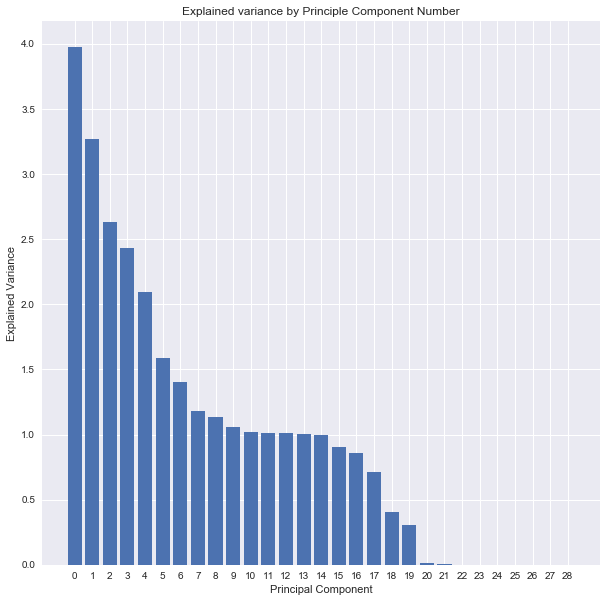

In [160]:
plt.figure(figsize=(10,10))
plt.bar(left = range(len(pca.explained_variance_)),height = pca.explained_variance_)
plt.title('Explained variance by Principle Component Number')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(range(len(pca.explained_variance_)));

The graph of explained variance by principal component shows us that only 19 principal components have a significant non-zero effect. Therefore, in the multiple linear regression model we will `n=19`.

In [158]:
pca_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,kWh
0,0.522871,-1.632831,-0.045971,-1.740311,-0.110825,-0.749794,-0.123423,-1.084722,0.105481,0.697715,...,-0.069683,0.054828,9.319373e-15,2.672638e-15,-1.764663e-15,-9.923069e-15,-4.526615e-15,1.879114e-15,6.754026e-16,0.548625
1,0.597180,-1.590272,-0.269491,-1.813608,-0.201214,-0.743989,-0.232930,-1.093988,-0.021672,0.680983,...,-0.057014,0.062079,-1.500306e-15,7.155766e-16,1.712615e-15,-2.269747e-15,-2.439993e-15,2.556693e-16,5.089496e-16,0.889426
2,0.696326,-1.498537,-0.466689,-1.809615,-0.219623,-0.651689,-0.357461,-1.095342,-0.240392,0.703142,...,-0.072492,0.018435,3.277369e-15,2.515506e-15,3.961129e-15,-3.373816e-16,-6.503620e-16,2.050811e-15,1.030231e-15,1.219046
3,1.216072,1.304190,-0.654195,-0.205796,-0.513599,-1.053223,-2.212407,0.953087,1.446059,0.025291,...,-0.044455,0.012284,-5.008747e-15,-1.819971e-15,4.558165e-15,-2.704967e-15,-1.935147e-16,-1.921709e-15,-1.807001e-16,1.636129
4,1.043305,1.318544,-0.643140,-0.260303,-0.532560,-1.033841,-2.185088,0.962045,1.530388,-0.011446,...,-0.040759,0.021863,-8.161552e-16,2.418395e-15,2.120712e-15,2.585608e-15,-4.056673e-15,9.431665e-16,4.815501e-16,2.158431


                            OLS Regression Results                            
Dep. Variable:                    kWh   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     159.2
Date:                Sat, 10 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:42:38   Log-Likelihood:                -11126.
No. Observations:                8758   AIC:                         2.229e+04
Df Residuals:                    8738   BIC:                         2.243e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.009      0.024      0.9

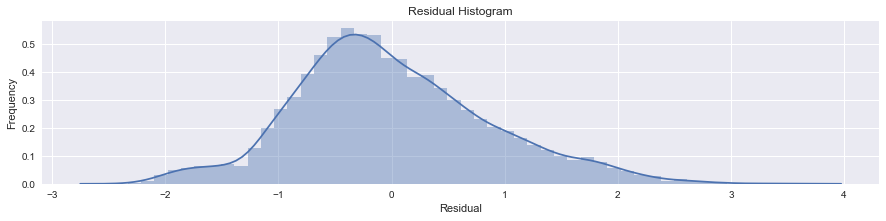

In [161]:

# Perform linear regression with the first N columns
n = 19
formula_start = 'kWh' + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

The results of this regression show that all but the intercept, pc4, pc10, pc11, pc14, pc16, and pc17 were significant and the residuals are normally fitted with only a slight right skew. However, the model only explains about 25% of the total variance (i.e. $R^{2} = 0.256$). Therefore, we can conclude that while a relationship can be found between weather and electricity usage, it is not the driving factor. More likely factors like work schedule play a bigger role. Levying tariffs based on the forecast may still have some value but it is clearly not the best approach.

#### 3.3 K-Means clustering of load curves

K-Means clustering is an effective tool in determining similarly patterned data points in a dataset. To put in simplest terms, the algorithm works by minimizing the euclidean distance between the each cluster center and data points. For more information on how K-Means clustering works, this [powerpoint](https://www.slideshare.net/SarahGuido/kmeans-clustering-with-scikitlearn) provides an excellent explanation.

In [83]:
clust_data = low_std_data.copy()
# We want to create a 24 hour load curve profile so we need to group by the hour
clust_data['hourofday'] = clust_data.DateTime.dt.hour
clust_grpd = clust_data.groupby(['LCLid','hourofday'])['kWh/hh'].mean()

clust_grpd.head()

LCLid      hourofday
MAC000003  0            1.790259
           1            1.019851
           2            0.806553
           3            0.771038
           4            0.731479
Name: kWh/hh, dtype: float64

In [75]:
# Unstack the df so that there is one row per customer and one column per hour of day
clust_unstckd = clust_grpd.unstack(level = 1)
clust_scld = clust_unstckd.apply(lambda x: preprocessing.scale(x),axis = 1)

In [76]:
X = clust_scld.as_matrix().astype('float')

There is no set way to determine the ideal number of clusters to use, however a common method is to use what's known as the "elbow rule." Essentially, you fit the data with an increasing number of clusters and calculate the score, and then plot the results. Where you see an "elbow," i.e. where the addition of more clusters has a less significant effect on the performance of the model, that is your ideal number of clusters.

In [77]:
# Determine the ideal number of clusters
no_clusters = range(1,11)
score = []
for k in no_clusters:
    model = KMeans(n_clusters= k).fit(X)
    score.append(model.score(X))

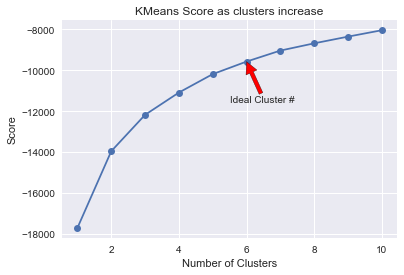

In [78]:
# Plot cluster scores
plt.plot(range(1,11),score,marker ='o')
plt.annotate('Ideal Cluster #',xy = (6,score[5]),xytext = (5.5, score[5]-2000),arrowprops = dict(facecolor = 'red'))
plt.xlabel('Number of Clusters');
plt.ylabel('Score');
plt.title('KMeans Score as clusters increase');

As you can see, there is not as sharp an elbow in this plot as you might typically expect. However, for the purposes of the project we will use 6 cluster.

In [79]:
# Using ideal cluster number, fit the data
centers = 6
clusters = KMeans(n_clusters=centers).fit(X)

In [80]:
# Check cluster distribution
for lab in range(centers):
    print(lab,sum(clusters.labels_ == lab))

0 357
1 152
2 339
3 68
4 221
5 374


Checking our cluster sizes we see that they are fairly evenly distributed. This tells us that a) six is an adequate number of clusters to choose and b) the data has been properly normalized.

In [81]:
labels = clusters.labels_
centroids = clusters.cluster_centers_

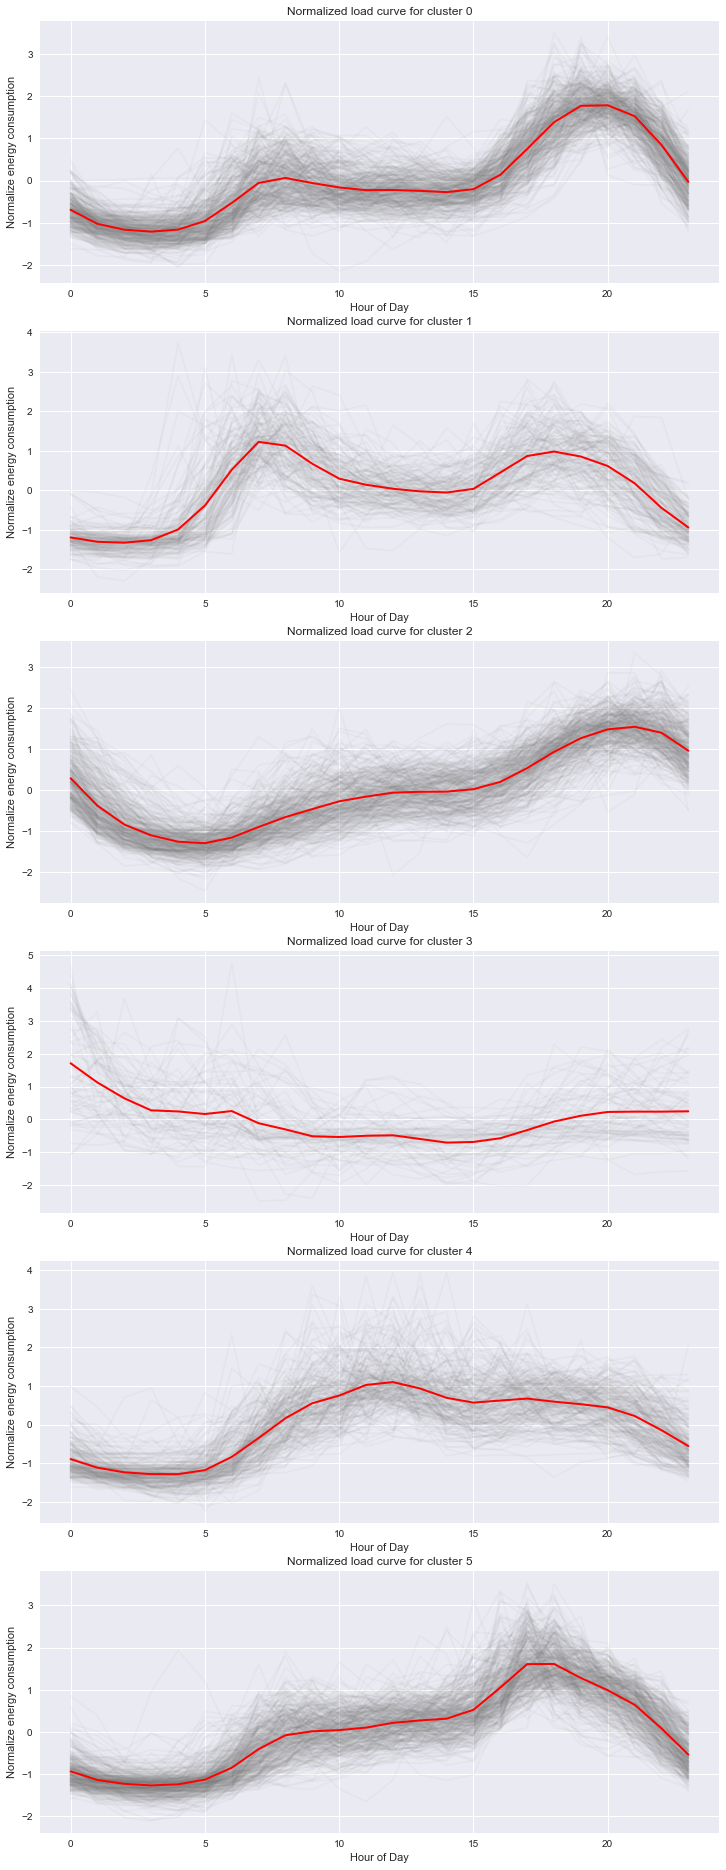

In [82]:
# Plot all load curves and their respective cluster center
fig = plt.figure(figsize=(10,30))

for cluster in range(len(centroids)):
    plt.subplot(centers + 1,1,cluster+2)
    cluster_members = X[labels == cluster,:]
    for member in range(len(cluster_members)):
        plt.plot(cluster_members[member,:],color = 'grey',alpha = 0.05)
    plt.plot(centroids[cluster],color = 'r',linewidth = 2)
    plt.xlabel('Hour of Day');
    plt.ylabel('Normalize energy consumption');
    plt.title('Normalized load curve for cluster ' + str(cluster))
plt.tight_layout(pad=0.4, w_pad=0.5)

Since time-of-use tariffs incentivize energy consumption during off-peak hours, households in cluster 3 are clearly the greatest beneficiaries with their minimum energy consumption occurring during the daytime. However, they are also the smallest cluster with only 68 households out 1511, so there is an opportunity for more low-income households to take advantage of this as well. The households with the most to gain are in clusters one and four. Cluster four has peak right around midday and bottoms out during the night, while cluster one shows a distinct bimodal peak during typical peak hours. Additionally, clusters zero, two, and five could also benefit from peak shifting as they all exhibit maxima during traditional evening peak hours.

While some energy consumption behavior is unavoidable, people working 9 to 5 jobs need to eat in the mornings and evenings, there are still a number of strategies to help distribute electricity consumption more evenly. For example, household tasks like running the laundry or dishwasher can be done overnight so as to take advantage of lower electricity prices. Another example could be utilizing natural light in the morning instead of turning on the lights in your house.

### 4. Conclusions
<a id = 'con'></a>

- Time of Use tariffs are fast-becoming a popular means for utility companies to entice households to change energy habits and reduce grid congestion
- The distribution of these tariffs in this particular case were non-ideal and resulted in trivial differences in consumption patterns
- Weather plays some role in impacting energy consumption but is not the primary driver
- By using k-means clustering utilities can identify load profiles that would benefit the most from utilizing ToU tariffs